# Projeto Semantix Big Data Engineer

### Questão 1
Enviar os dados para o HDFS

In [ ]:
# Em um terminal, primeiro baixar os dados do projeto para a pasta spark do treinamento

# sudo curl -O https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/04bd3419b22b9cc5c6efac2c6528100d_HIST_PAINEL_COVIDBR_06jul2021.rar

In [ ]:
# Em seguida, descompactar o arquivo formato .rar

# sudo unrar x 04bd3419b22b9cc5c6efac2c6528100d_HIST_PAINEL_COVIDBR_06jul2021.rar

In [ ]:
# Enviar os arquivos .csv descompactados para o diretório input dentro da pasta spark

# sudo mv *.csv /home/bruno/spark/input

In [ ]:
# Acessar o namenode

# docker exec -it namenode bash

In [ ]:
# Criar uma pasta no HDFS para salvar os arquivos .csv

# hdfs dfs -mkdir -p /user/bruno/projeto/covid19

In [ ]:
# Enviar os arquivos .csv para a pasta recentemente criada

# hdfs dfs -put /input/*.csv /user/bruno/projeto/covid19

In [ ]:
# Verificar se os arquivos foram enviados corretamente

!hdfs dfs -ls /user/bruno/projeto/covid19

### Questão 2
Otimizar todos os dados do hdfs para uma tabela Hive particionada por 
município

In [ ]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [ ]:
# Criando Spark Session

spark = SparkSession.builder.appName("Projeto do treinamento de Big Data Engineer da Semantix").getOrCreate()

In [ ]:
# Verificar como está estruturado o arquivo
# Importante para saber como será feita a leitura do mesmo

!hdfs dfs -cat /user/bruno/projeto/covid19/HIST_PAINEL_COVIDBR_2020_Parte1_06jul2021.csv

In [ ]:
# Como visto anteriormente, o arquivo contém um cabeçalho e está separado por ;
# Agora vamos ler esses arquivos e armazená-los em um dataframe

painel_covid = spark.read.csv("/user/bruno/projeto/covid19", sep=";", header=True)

In [ ]:
# Mostrando os 5 primeiros dados do dataframe

painel_covid.show(5)

In [ ]:
# Mostrando o schema do dataframe

painel_covid.printSchema()

In [ ]:
# Otimizar os dados por tabelas, particionadas por município

painel_covid.write.saveAsTable("dados_covid_municipio", mode="overwrite",partitionBy="municipio")

In [ ]:
# Confirmar se os dados foram salvos corretamente no diretório

!hdfs dfs -ls "hdfs://namenode:8020/user/hive/warehouse/"


### Questão 3
Criar as 3 vizualizações pelo Spark com os dados enviados para o HDFS

In [ ]:
# 1: Mostrando o total de casos recuperados confirmados

casos_recuperados_confirmados = painel_covid.select(max("Recuperadosnovos").alias("Casos_recuperados_confirmados"))
casos_recuperados_confirmados.show()

In [ ]:
# 2: Contabilizando a quantidade de casos acumulados, separados por Região

casos_acumulados_regiao = painel_covid.groupBy("regiao").agg(count("casosAcumulado").alias("Casos_acumulados"))
casos_acumulados_regiao.show()

In [ ]:
# 3: Contabilizando a quantidade de óbitos acumulados por Estado

obitos_acumulados_estado = painel_covid.groupBy("estado").agg(count("obitosAcumulado").alias("Óbitos_acumulados"))
obitos_acumulados_estado.show()

### Questão 4
Salvar a primeira visualização como tabela Hive

In [ ]:
casos_recuperados_confirmados.write.format("csv").saveAsTable("Casos_Recuperados")

In [ ]:
# Para confirmar que foi salvo

spark.read.table("Casos_Recuperados").show()

### Questão 5
Salvar a segunda visualização com formato parquet e compressão snappy

In [ ]:
casos_acumulados_regiao.write.option("compression", "snappy").parquet("/user/bruno/projeto/covid19/dados/casos_acumulados_regiao")


In [ ]:
# Para confirmar que foi salvo

!hdfs dfs -ls "/user/bruno/projeto/covid19/dados/casos_acumulados_regiao"

### Questão 6
Salvar a terceira visualização em um tópico no Kafka

In [ ]:
obitos_acumulados_estado.selectExpr("to_json(struct(*)) As value").write.format("kafka").option("kafka.bootstrap.servers","kafka:9092").option("topic", "topico_obitos_acumulados_estado").save()

# Para verificar, basta acessar kafka pelo terminal, com o comando 'docker exec -it kafka bash'
# e em seguida digitar o comando 'kafka-topics.sh --bootstrap-server kafka:9092 --list'
# O novo tópico criado 'topico_obitos_acumulados_estado' está na listagem

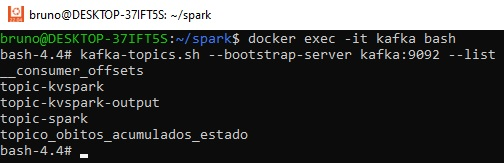

### Questão 7
Criar a visualização pelo Spark com os dados enviados para o HDFS:

In [ ]:
# Primeiro, mostrando as tabelas criadas.
# Desconsiderar a repetição da tabela "casos_recuperados_confirmados, pois foi dado o comando duas vezes durante o exercício
# Também desconsiderar a tabela juros, pois é de outro exercício ao longo do treinamento

spark.sql("SHOW TABLES").show()

In [ ]:
spark.sql("SELECT * from casos_recuperados").show(10)